## Naive Bayes Test Case on Cogito Corpus

In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
## List folders in parent directory
PATH = 'assets/dataset/news_corpus/'
folders = os.listdir(PATH)
folders

['Business', 'Corruption', 'Finance']

In [3]:
os.path.join(PATH, folders[0])

'assets/dataset/news_corpus/Business'

In [4]:
from collections import defaultdict

## load files into a defaultdict for processing
df = defaultdict(lambda:defaultdict(list))

## For each file in each category, create a dictionary entry 
for category in folders:
    files = os.listdir(os.path.join(PATH, category))
    
    ## only read in the text files
    files = [i for i in files if '.txt' in i]
    num_docs = 0
    
    for file in files:
        file_path = os.path.join(PATH, category, file)
        
        with open(file_path, encoding="utf8") as fp:
            line= fp.readlines()
            df[category][num_docs] = line
            num_docs+=1

## Throw everything into a pandas dataframe for easy processing
df = pd.DataFrame.from_dict(df)

## Turn column names (labels into a variable)
df = pd.melt(df, var_name = "Label", value_name="Features")
df.head()

,Label,Features
0,Business,"[﻿Intel Earnings May Send Stock Higher\n, \n, ..."
1,Business,[﻿Missguided hits high street as sales rise 70...
2,Business,"[﻿Manulife to Sell Insurance Through DBS\n, \n..."
3,Business,[﻿David's Tea dips into U.S. with IPO; Wall st...
4,Business,[﻿The Bay stocks up on upscale bargains; Saks ...


In [5]:
df.shape

(300, 2)

In [6]:
## Set up randomization for test set and training set 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Features'].astype('U'), 
                                                    df['Label'].astype('U'), 
                                                    random_state = 123, 
                                                    test_size = 0.4)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

#Just do my preprocessing inside the Vectorizer call
vec = CountVectorizer(lowercase=True,stop_words="english",ngram_range=(1,2))  #creates a sparse matrix with each word as a column and each document is a row

#Fit the Vectorizer on the training set
train_features = vec.fit_transform(X_train) #fit builds the count matrix out of the data (normally training data), transform maps what's fed into transform to the count matrix

#Use that model to transform the test 
test_features = vec.transform(X_test)

In [8]:
train_features

<180x44938 sparse matrix of type '<class 'numpy.int64'>'
	with 83605 stored elements in Compressed Sparse Row format>

In [9]:
train_features.todense()

matrix([[0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
vec.get_feature_names()[1000:1010]

['28 34',
 '28 744',
 '28 84',
 '28 addition',
 '28 aims',
 '28 cent',
 '28 cents',
 '28 company',
 '28 competitive',
 '28 deliberating']

In [11]:
#Run model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
model = nb.fit(train_features,y_train)

# And check out test score
model.score(test_features,y_test)

0.975

['Business' 'Corruption' 'Finance'] 
 [[41  0  1]
 [ 1 40  0]
 [ 1  0 36]]


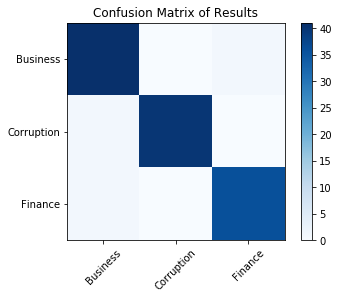

In [12]:
## Check out precisiona nd recall
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

pred_labels = model.predict(test_features)

#Generate confusion matrix
c = confusion_matrix(y_test, pred_labels, labels=model.classes_)
print(model.classes_,"\n", c)

# Y axis is actual values, x axis is predicted values
# Two business classified as as Finance
# One corruption classified as business
# Four finance classified as business

#A little bit of plotting
plt.imshow(c, cmap=plt.cm.Blues, interpolation='None')
plt.title("Confusion Matrix of Results")
plt.colorbar()
tick_marks = np.arange(len(model.classes_))
plt.xticks(tick_marks, model.classes_, rotation=45)
plt.yticks(tick_marks, model.classes_)
plt.show()

#the columns are True for confusion matrix

In [13]:
## And note that this is not a black box.  We can see feature importance easily
#Clearly the results can be improved even further from better preprocessing

print("Top Ten Features per Class: ")
names = vec.get_feature_names()
for i, class_label in enumerate(model.classes_):
    top10 = np.argsort(np.exp(model.coef_[i]))[-10:]
    print('{} : \t {}'.format(class_label,", ".join(names[j] for j in top10[::-1])))

Top Ten Features per Class: 
Business : 	 said, year, company, sales, quarter, profit, earnings, million, billion, new
Corruption : 	 mr, said, zhou, corruption, party, china, mr zhou, state, charges, political
Finance : 	 inflation, prices, year, said, bank, rate, cent, price, central, february
